# Contextual Multi-Armed Bandits 

This notebook is a gentle introduction to the Multi-Armed Bandit (MAB) problem. The goal is to make this topic understandable on an intuitive level without going too deep into the technicalities. I will refrain from any mathematical notation here and focus on the reasonings while mostly staying on the surface of what is a topic with a deep research history. For those inclined to some more rigor, I would encourage to go through this Cornell tutorial which I found very helpful: http://www.cs.cornell.edu/~adith/CfactSIGIR2016/

After an introduction to the topic, the main body of this notebook uses implementations of different MAB algorithms by David Cortes (1) to do "online" testing of simulated advertisement click-through data. 

(1) https://github.com/david-cortes/datascienceprojects 

<img src='images/Good-Bad-Ugly.jpg' width='600' height='600'/>

Source: "The Good, the Bad and the Ugly", 1966

### Multi-Armed Bandits <a class="tocSkip">
    
The core idea behind MABs can be illustrated by considering the origin of the name. A One-Armed Bandit is a slot machine used for gambling (named so after the lever that needs to be pulled every time the machine is played). In a Multi-Armed Bandit setup, we imagine a scenario where an agent has the option to play any slot machine out of a number of available machines (i.e., she needs to decide between more than just one arm to pull each round). Crucially, the agent does not know which machine provides the best chances of winning (i.e., the highest expected value). Starting to randomly select machines and play will help to form a hypothesis about which machine is best. However, if the agent would only play at what she currently believes to be the best machine, she might miss out on potentially discovering that another machine is even better. The challenge becomes thus to balance **exploitation** of the currently known best machine (by repeatedly playing it) with the **exploration** of new machines (which might be better or worse). 

**Considering a real-world example;** if we were running a newspaper website and our goal was for website visitors to more often click on an article, we could experiment with displaying different articles at the top of the page. Maybe people prefer politics over economic news or click more readily on crime stories and gossip. In this case, each article represents an arm of our Multi-Armed Bandit and the goal is to find a policy of choosing articles ("pulling arms") that maximizes the click-rate of website visitors. One possible approach would be to run an experiment and randomly display headlines to users until we have enough data to know which one works best overall (an approach also known as **A/B testing**). A/B testing has a period of pure exploration (learning about the world) followed by a period of pure exploitation (taking advantage of what was learned). However, this approach has obvious drawbacks: most troublesome, we would lose revenues by devoting an equal amount of tries to good and bad options until we have gathered the data. There is also a limited amount of experiments we can run this way and there is a fairly long turn-around time until we know for sure which option works best. The rest of this notebook will take a closer look at alternative algorithms that could yield better results, especially when it comes to a larger number of "arms" together with a limited number of trials.  

**A note of caution:** It is worth stating that MABs do not necessarily remove the need for A/B tests. A great discussion of when to use which approach can be found here: https://conversionxl.com/blog/bandit-tests/


### Contextual Multi-Armed Bandits <a class="tocSkip">
    
The Contextual Multi-Armed Bandit extends the idea of the original MAB problem by adding information about each slot machine. In this setup, the machine is no longer just a black box with a stable (yet unknown) probability distribution for winning, but the probability of winning at each time step is now connected to some information (i.e., context) available at the time of decision making.  

The relevance for our news website example is obvious since the viewer identity will have some connection to her headline preferences. Information about the IP address, the user device, last pages visited, recent search history, and other is often available. For each user, there is likely a different probability distribution for clicking on each possible headline, and a Contextual Bandit algorithm can do better by adjusting its best guess about what headline to show next based on the user information available. 

Here is an example of how the Washington Post implemented Contextual Bandits: https://developer.washingtonpost.com/pb/blog/post/2016/02/08/bandito-a-multi-armed-bandit-tool-for-content-testing/

### Contextual Multi-Armed Bandits vs. Multi-label Classification <a class="tocSkip">

On the surface, the MAB problem looks very similar to the multi-class classification problem, where an algorithm is trained to associate labels with features (e.g., "user X likes political headlines most"). However, in the MAB setting, we do not have perfect information about all the different possible outcomes. Once we show a user a financial news headline, we will not know what would have happened if we had shown any other headline. Maybe that user would have also clicked on the latest tech news as well or was just there to browse. The algorithm cannot be trained by simply comparing its choice to fully revealed user preferences (which we don't have), but can only be trained against one user response at a time. 

**However, some similarity remains:** the MAB algorithms in this notebook rely on a simple **multi-class linear regressor** that attempts to estimate user click probability given a user context based on all users it has seen so far (as a machine learning problem). The MAB algorithms differ in **how to choose amongst different options given the predicted probabilities.**  

### Approach of this notebook: <a class="tocSkip">
    
This notebook will simulate whether website visitors will click on a specific advertisement displayed to them ("click-through rates") based on an existing dataset of click-through rates for online ads (provided by the online advertising platform Avazu)(1). This approach is described in more detail in section 1). 

Using the simulated user click-through-rate, this notebook will explore **three different approaches** to the MAB problem (described in more detail in section 2):

- **Upper confidence bound (UCB)**  
- **Greedy exploration** 
- **Thompson sampling** 

The algorithms will be tested against three different environments:

- **30 arms** (i.e., an arbitrary number for "many" arms) 
- **30 arms with sparse rewards**
- **10 arms** (i.e., an arbitrary number for "few" arms)

The implementation of the algorithms comes courtesy of David Cortes who has built a Python package for various online and offline MAB implementations (2). Another popular open-source library for MAB algorithms is **Vowpal Wabbit** (originally developed at Yahoo! Research, and currently at Microsoft Research) (3).

All of the algorithms rely on a multi-class classifier to predict the likelihood of an individual user clicking on a variety of different ad options, yet employ different policies for choosing ads based on the classifier predictions. Each algorithm gets trained in batches of 50 users until it has run through a dataset of 10,000 users. The choices of each algorithm get recorded along the way so as to evaluate them at the end. 

(1) https://www.kaggle.com/c/avazu-ctr-prediction/data  
(2) https://contextual-bandits.readthedocs.io/en/latest/index.html#
(3) https://github.com/VowpalWabbit/vowpal_wabbit/wiki


### A note on Online vs. Offline training <a class="tocSkip">
    
One of the key characteristics of testing a new MAB policy is whether this will happen live with real responses or is based on data generated while a different system was deployed. The former is referred to as **online evaluation** while the latter is known as **offline evaluation.** This notebook will focus on **online evaluation**, but following here is a brief description of the issues arising in offline evaluation.

The core problem of training a new MAB system on data generated (with real interactions) by another MAB system (i.e., offline training) is the lack of information about all possible outcomes. Since we don't know what a website visitor's reaction would have been to something she was not shown in that moment, we cannot easily evaluate (and thus train) a new system that makes exactly that choice. One possible solution would be to **model all other outcomes** by using the recorded data as training set. However, this runs into the issue of **selection bias.** If, for example, the original system tended to show website visitors with an IP address from a college campus always the same headline content (i.e.,  articles it deemed interesting for young people), then the dataset will not contain examples (or only very few examples) of cases where this group was exposed to other type of content and we cannot realistically hope to model these cases with any degree of accuracy. In other words, if our new system picked different types of headline stories for this group of people, we could not confidently evaluate these choices. One solution to this conundrum is to **model the bias** inherent in the collected data. If we know that the original system shows political news to 80% of college IP addresses and financial news to 20%, then our model can weigh these two types of observations differently. In other words, if we know the probability distribution of the original model to do a certain action, then we can account for this mismatch with so called "counterfactual models". We can qualify (i.e., weigh) each observed outcome by the likelihood of the action that triggered it (i.e., the frequency of that action in the dataset). Specifically, we can divide the positive outcomes (user "clicked", coded as 1's) by the probability of the system choosing this action. Taking the average of this gives us the "utility" of choosing that action. What this does in practice, is to put greater weight on positive examples of rare choices.* 

If we want to evaluate an action taken by the new system, we can do so by taking into account both the new system's, and the original system's propensity of choosing that action. Specifically, we can divide the new system's probability by the old system's probability and average over all such cases to arrive at the so called Inverse Propensity Score, IPS. In practical terms, if the new system has a very high chance of taking an action which has lead to a few positive outcomes under the original system (which had a very low chance of taking this action), this action receives a high evaluation score. This accounts for the fact that there is likely only very few such examples in the dataset (i.e., de-biases the evaluation score). This approach allows to test new models on log data that was generated with a different model. For a more detailed description of this approach (as well as other approaches such as Self-Normalized Estimator, Doubly Robust Estimator, and the Slates Estimator), I would again recommend the following Cornell tutorial: http://www.cs.cornell.edu/~adith/CfactSIGIR2016/ 

**For this to work, all actions should ideally have a non-zero probability to be chosen (and we need to know that probability). In case we do not know the propensity of a system to choose action x, we need to estimate this first. This is relevant for example when users are asked to rate movies.* 

### Other useful sources of information on MAB algorithms <a class="tocSkip">

- Overall introduction to MAB algorithms: https://towardsdatascience.com/contextual-bandits-and-reinforcement-learning-6bdfeaece72a 
- Introduction to MABs with synthentic data: https://getstream.io/blog/introduction-contextual-bandits/
- Introduction to A/B testing and AdWords: https://unbounce.com/ppc/boost-your-adwords-click-through-rate-a-b-testing-copy/
- Tensorflow implementation of MAB algorithms: https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-1-fd544fab149
- Numpy implementation of MAB algorithms: https://harderchoices.com/2018/01/20/rl-basics-and-simple-k-armed-bandit-problem/
- Cornell introduction to de-biasing offline data for training: http://www.cs.cornell.edu/~adith/CfactSIGIR2016/

In [616]:
import numpy as np 
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE

from contextualbandits.online import BootstrappedUCB, BootstrappedTS, SeparateClassifiers,\
            EpsilonGreedy, AdaptiveGreedy, ExploreFirst, ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Simulating-user-click-through-behavior" data-toc-modified-id="1-Simulating-user-click-through-behavior-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1 Simulating user click-through behavior</a></span><ul class="toc-item"><li><span><a href="#1.1-Loading-the-original-dataset" data-toc-modified-id="1.1-Loading-the-original-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>1.1 Loading the original dataset</a></span></li><li><span><a href="#1.2-Use-stochastic-simulation-to-create-click-through-labels" data-toc-modified-id="1.2-Use-stochastic-simulation-to-create-click-through-labels-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>1.2 Use stochastic simulation to create click-through labels</a></span></li><li><span><a href="#1.3-Taking-a-look-at-the-results" data-toc-modified-id="1.3-Taking-a-look-at-the-results-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>1.3 Taking a look at the results</a></span></li></ul></li><li><span><a href="#2-Testing-contextual-bandit-algorithms-against-the-dataset" data-toc-modified-id="2-Testing-contextual-bandit-algorithms-against-the-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2 Testing contextual bandit algorithms against the dataset</a></span><ul class="toc-item"><li><span><a href="#2.1-Setting-up-the-models" data-toc-modified-id="2.1-Setting-up-the-models-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>2.1 Setting up the models</a></span></li><li><span><a href="#2.2-Running-models-against-dataset" data-toc-modified-id="2.2-Running-models-against-dataset-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>2.2 Running models against dataset</a></span></li></ul></li><li><span><a href="#3-Visualizing-the-results" data-toc-modified-id="3-Visualizing-the-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3 Visualizing the results</a></span><ul class="toc-item"><li><span><a href="#3.1-Choice-among-30-ads" data-toc-modified-id="3.1-Choice-among-30-ads-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>3.1 Choice among 30 ads</a></span></li><li><span><a href="#3.2-Choice-among-30-ads-with-sparse-rewards" data-toc-modified-id="3.2-Choice-among-30-ads-with-sparse-rewards-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>3.2 Choice among 30 ads with sparse rewards</a></span></li><li><span><a href="#3.3-Choice-among-10-ads" data-toc-modified-id="3.3-Choice-among-10-ads-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>3.3 Choice among 10 ads</a></span></li></ul></li></ul></div>

## 1 Simulating user click-through behavior

In order to simulate online evaluation of a Contextual Bandit algorithm, this notebook uses an offline (i.e., existing) multi-label classification dataset and attempts to simulate user behavior. The aim is **not** to predict actual user behavior, but to randomly generate hypothetical user responses that follow two rules: 

- **Similar users behave similarly on average:** users with similar user profiles (e.g., demographics, devices, search history, etc.,) must have similar propensities to click on a certain type of ad. In other words, two similar users might click on ad 1 with around 20% probability, on ad 2 with around 5% probability and ad 3 with near 0% probability. This ensures that the **context matters.** 
- **Each ad targets one user group only:** each ad must be effective at targeting a certain range of similar users, i.e., an ad might work well for some group of users and not well for all other user groups (in a Gaussian kind of distribution) 

Implementing the above rules relies on the assumption that user-similarity can be expressed using a dimensionality reduction technique such as t-SNE (van der Maaten and Hinton, 2008)(1). Thus, the similarity of users across an n-dimensional feature space can be represented as a single floating point number (the output of the dimensionality reduction technique). Two users are similar if their associated dimensionality-reduced features are similar. 

Once we have simulated user-responses (i.e., labels) for all possible ads, we can use the dataset for online training. However, rather than revealing all labels to the algorithm during training, we only ever reveal those labels that the algorithm picks. Knowing all labels for all options and all samples allows to easily evaluate different algorithms against each other. 

The below algorithm implements this in the following way: 

1. Map user features to a single dimension using t-SNE 
2. Use the t-SNE dimension as input for a Gaussian curve, such that each value is mapped to a point on the Gaussian curve. Crucially, the mean and standard deviation is randomized such that each simulated ad has its own distribution among the users 
3. Use the Gaussian values as input for a beta curve which represents the actual likelihood for each user to click on each ad type. This step essentially introduces some randomness to account for the fact that the users' behavior is not completely determined by the characteristics captured in the dataset. Even though a group of users might have a base 10% chance of clicking, the actual likelihood for individuals within that group might vary between 5% and 20%
4. "Roll a dice" to determine if a user actually clicked or not. This converts probabilities to binary actions, i.e., 0 for "did not click" and 1 for "clicked" with a chance determined by each user's propensity to click. 

The t-SNE dimension is not part of the features that the algorithm gets to evaluate before making its decision about which ads to show. It is merely used to simulate user behavior in every possible situation. 

#### A note on beta distributions: 

Beta distributions represent the confidence we have that the expected value of a probability distribution (whose real shape we don't know) is a certain value. It is a density function (i.e., the area under the curve sums to 1, or 100%). The x-axis does not represent an individual value, but rather an average value. The fewer number of samples went into estimating it, the flatter the distribution is going to be (i.e., the less certain we are)(2) 


(1) http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf <br/>
(2) http://varianceexplained.org/statistics/beta_distribution_and_baseball/

### 1.1 Loading the original dataset 

The dataset contains user data of website visitors recorded over the course of one day provided by the online advertising platform Avazu (1). There are 4,577,464 entries, each with the following data fields: 

- **id:** -- ad identifier, this will be replaced with the simulated ad data 
- **hour:** -- format is YYMMDDHH, on Sept. 11, 2014 UTC
- **C1** -- anonymized categorical variable
- **banner_pos** -- banner position of ad on website 
- **site_id** -- website id 
- **site_domain**
- **site_category**
- **app_id**
- **app_domain**
- **app_category**
- **device_id**
- **device_ip**
- **device_model**
- **device_type**
- **device_conn_type**
- **C14-C21** -- anonymized categorical variables

(1) https://www.kaggle.com/c/avazu-ctr-prediction/data

In [1036]:
# Download full dataset 
dataframe = pd.read_csv("C:\\Users\\Philipp Sorgenfrei\\Desktop\\Github\\data\\Click\\test.gz",compression='gzip')

In [40]:
# a look at the dataset 
dataframe.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000017e+19,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,8330,320,50,761,3,175,100075,23
1,1.000018e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
2,1.000055e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
3,1.000109e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,...,1,0,18648,320,50,1092,3,809,100156,61
4,1.000138e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,...,1,0,23160,320,50,2667,0,47,-1,221


### 1.2 Use stochastic simulation to create click-through labels

The below function executes the algorithm described above. It extracts a specified number of sample observation from the original dataset and creates labels (1 == "click", 0 == "no click") for a number of specified ad choices for each observation. To reduce the complexity and run-time, it will only use the anonymized categorical variables as features.

In [1166]:
def processData(num_samples, num_ads): 
    
    print("extract data..")
    # extract all numercial columns (anonymized user data) and the first 10,000 rows 
    df = dataframe[['C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']]
    df = df.loc[:num_samples, :]
    
    print(df.shape)
    
    # define function that re-scales a range of numbers 
    def squeeze(upper, lower, values): 
        result = ((upper - lower)*(values - min(values)) / (max(values) - min(values))) + lower
        return result 
    
    # define function that returns a click probability from a beta function 
    def set_click_probability(tSNE, modulator): 
        eps = 0.00001 # prevents zero alpha values 
        click_prob = np.random.beta((tSNE+eps)*modulator,100,size=1)
        return click_prob.item()
    
    # define function that returns gaussian curve (as y values for a range of x values)
    def gaussian(x, mean=0, std=1):
        mean = mean
        std = std
        y = np.exp(-np.square(x-mean)/2*variance)/(np.sqrt(2*np.pi*variance))
        return y 
    
    # define range to which t-SNE dimension will be scaled 
    range_min, range_max = (-35, 35) 
    
    print("run t-SNE..")
    # run dimensionality reduction on features 
    tsne = TSNE(n_components=1, verbose=0, perplexity=40, n_iter=10000)
    tsne_results = tsne.fit_transform(df.values)
    
    df["tSNE"] = tsne_results
    df["tSNE_norm"] = squeeze(range_max, range_min, tsne_results)
    
    print("create Gaussian distribution..")
    # create random Gaussian distributions based on similarities of users. "mean" and "std" introduce some randomness  
    for i in range(num_ads):
        mean = np.random.uniform(range_min, range_max, 1)
        std = np.random.uniform(1, 3, 1)
        df["gaussian_ad"+str(i+1)] = gaussian(df["tSNE_norm"], mean, std)


    # roll the dice for each interaction 
    df["Dice"] = np.random.uniform(0, 1, df.shape[0])
    
    print("create labels..")
    # create labels for each ad 
    label_list = []
    for i in range(num_ads): 
        
        # create beta distribution for click probability. Modulator introduces some randomness to the beta distrubtion  
        modulator = mean = np.random.uniform(5, 10, 1)
        df["Ad_"+str(i+1)+"_clickProb"] = df.apply(lambda x: set_click_probability(x[11+i], modulator), axis = 1)
        df["Ad_"+str(i+1)+"_clickProb"] = (df["Ad_"+str(i+1)+"_clickProb"] + 0.0001) * 1

        # based on click probability and dice value for each user interaction, label either 1 ("click") or 0 ("did not click")
        df.loc[df["Ad_"+str(i+1)+"_clickProb"] >= df["Dice"], "LABEL_Ad"+str(i+1)] = 1
        df.loc[df["Ad_"+str(i+1)+"_clickProb"] < df["Dice"], "LABEL_Ad"+str(i+1)] = 0
        label_list.append("LABEL_Ad"+str(i+1))

    # split dataframe into features and labels 
    X = np.array(df[['C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']])
    y = np.array(df[label_list])
    return X, y, df

In [1167]:
# running the algorithm
X, y, df = processData(num_samples=10000, num_ads=30)

extract data..
(10001, 9)
run t-SNE..
create Gaussian distribution..
create labels..


### 1.3 Taking a look at the results 

The simulated user CTR has two properties: 

1. **Some ads are better than others overall** (see subsequent plot). In this case, the overall likelihood of an ad to be clicked on varies between 0.4% and 1.6%
2. **The CTR is not evenly distributed, but clustered by user similarity**. In other words, users that are similar based on their t-SNE score have a similar base likelihood of clicking (with some statistical noise - see second plot below) 

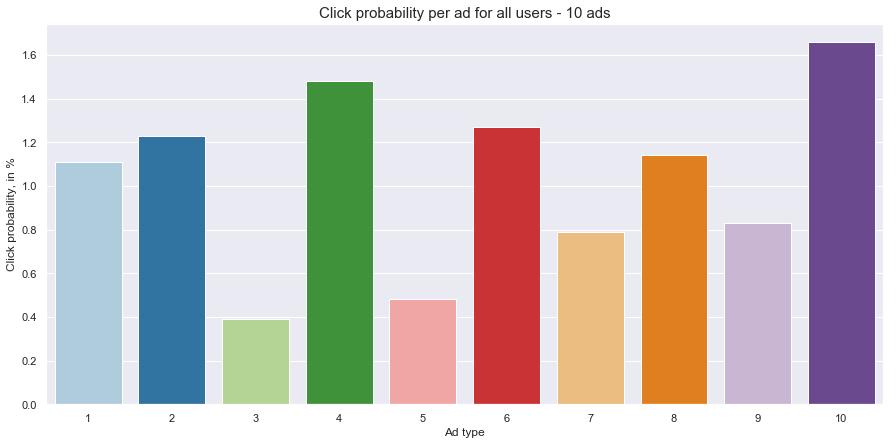

In [1146]:
# extract overall click-through rates for each ad type  
CTR_df = pd.DataFrame()
CTR = []
Label = []
for i in range(y.shape[1]):
    CTR.append(y[:,i].mean(axis=0)*100)
    Label.append(i+1)
CTR_df['CTR'] = CTR
CTR_df['Label'] = Label

# plot CTRs
sns.set(rc={'figure.figsize':(15,7)}, palette = "Paired")
fig, ax = plt.subplots()

sns.barplot(x=CTR_df['Label'], y=CTR_df['CTR'])
    #sns.lineplot(x=steps, y=np.repeat(y[:,i].mean(axis=0), 10), label="Ad "+str(i+1)+" CTR")

ax.set_title("Click probability per ad for all users - 10 ads", {'fontsize': 15})
ax.set_xlabel("Ad type"), ax.set_ylabel("Click probability, in %")

fig.show()

All 10,000 users fall somewhere on the x-axis number line below (i.e., have a t-SNE score between +35/-35). Each dot below represents the click likelihood of one user for one of three example ads. 

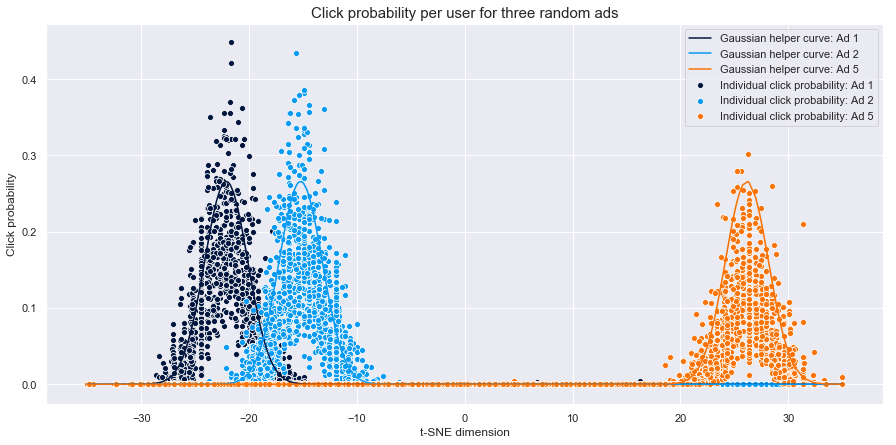

In [1137]:
# plot click probability 
colors = sns.xkcd_palette(["navy", "azure", "orange"])
sns.set(rc={'figure.figsize':(15,7)}, palette = sns.set_palette(colors, color_codes=False))
fig, ax = plt.subplots()

sns.scatterplot(x=df["tSNE_norm"], y=df["Ad_1_clickProb"], label="Individual click probability: Ad 1")
sns.lineplot(x=df["tSNE_norm"], y=df["gaussian_ad1"]/3, label="Gaussian helper curve: Ad 1")
sns.scatterplot(x=df["tSNE_norm"], y=df["Ad_2_clickProb"], label="Individual click probability: Ad 2")
sns.lineplot(x=df["tSNE_norm"], y=df["gaussian_ad2"]/3, label="Gaussian helper curve: Ad 2")
sns.scatterplot(x=df["tSNE_norm"], y=df["Ad_5_clickProb"], label="Individual click probability: Ad 5")
sns.lineplot(x=df["tSNE_norm"], y=df["gaussian_ad5"]/3, label="Gaussian helper curve: Ad 5")

ax.set_title("Click probability per user for three random ads", {'fontsize': 15})
ax.set_xlabel("t-SNE dimension"), ax.set_ylabel("Click probability")

fig.show()

The below plot shows how click likelihood is translated into actual clicks. Each cross on the zero, and one line represents an event (0 == "no click", 1 == "click") which is random-uniformly determined based on the individual user probability of clicking (dots) 

(Text(0.5, 0, 't-SNE dimension'), Text(0, 0.5, 'Click probability'))

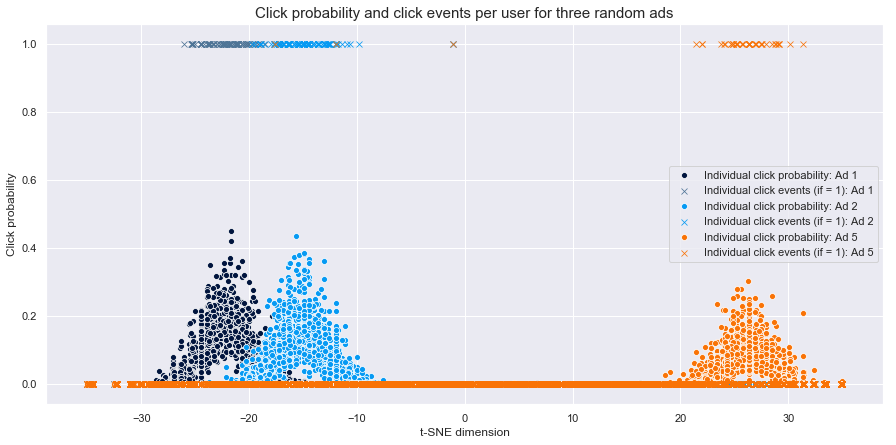

In [1139]:
# plot clicks 
colors = sns.xkcd_palette(["navy", "cadet blue", "azure", "azure", "orange", "orange"])
sns.set(rc={'figure.figsize':(15,7)}, palette = sns.set_palette(colors, color_codes=False))
fig, ax = plt.subplots()

sns.scatterplot(x=df["tSNE_norm"], y=df["Ad_1_clickProb"], label="Individual click probability: Ad 1")
sns.scatterplot(x=df["tSNE_norm"], y=df["LABEL_Ad1"], label="Individual click events (if = 1): Ad 1", marker="x")

sns.scatterplot(x=df["tSNE_norm"], y=df["Ad_2_clickProb"], label="Individual click probability: Ad 2")
sns.scatterplot(x=df["tSNE_norm"], y=df["LABEL_Ad2"], label="Individual click events (if = 1): Ad 2", marker="x")

sns.scatterplot(x=df["tSNE_norm"], y=df["Ad_5_clickProb"], label="Individual click probability: Ad 5")
sns.scatterplot(x=df["tSNE_norm"], y=df["LABEL_Ad5"], label="Individual click events (if = 1): Ad 5", marker="x")

ax.set_title("Click probability and click events per user for three random ads", {'fontsize': 15})
ax.set_xlabel("t-SNE dimension"), ax.set_ylabel("Click probability")

## 2 Testing contextual bandit algorithms against the dataset

### 2.1 Setting up the models 

The following implementation of the Contextual MAB algorithms is due to David Cortes and taken from his github account (https://github.com/david-cortes/datascienceprojects). Here is a brief description of how they work in a nutshell: 

- **Upper confidence bound (UCB):** The UBC algorithm fits a number of classifiers to subsets of the already seen data where each classifier tries to predict the likelihood of a reward for all possible arms. The UBC algorithm then compares the upper confidence bound for each prediction for each arm across all classifiers and chooses the arm with the overall highest value as next arm to pull  
- **Greedy exploration:** The epsilon-Greedy algorithm starts out by randomly exploring arms (e.g., for an initial 1000 trials) and then exploits the then as best identified arm most of the time while also devoting some time to additional random exploration. Setting epsilon to 95% makes the algorithm use what it thinks to be the best arm 95% of the time while devoting 5% of trials to other arms randomly. This is obviously a good strategy if the algorithm correctly identifies the best arm in all cases, but it can also get stuck at exploiting suboptimal arms (at least for a while)
- **Thompson sampling:** Unlike the Epsilon-Greedy algorithm which divides its trials between exploiting the best while sometimes randomly exploring the rest, the Thompsons algorithm chooses arms corresponding to the probability of them being the best 

All of the algorithms rely on a binary classifier to predict the likelihood of an individual user clicking on a variety of different ad options. This classifier gets trained in batches of 50 users, i.e., it gets exposed to data of the first 50 users, makes a prediction for the click-through rate for a number of ads, and updates its weights based on the result. It then receives input for another 50 users, makes predictions, and updates its weights based on all users it has seen so far (i.e., 100). This goes on until it has run through the entire dataset of users (10,000 in this notebook). While this is happening, the number of correct predictions are recorded for each algorithm to be able to compare performance by the end. 

In [1168]:
# set up models 
nchoices = y.shape[1]
base_algorithm = LogisticRegression(random_state=123, solver='lbfgs')
beta_prior = ((2, 7), 2) # until there are at least 2 observations of each class, will use prior Beta(3, 7)

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices, beta_prior=beta_prior)

models = [bootstrapped_ucb, bootstrapped_ts, epsilon_greedy]

### 2.2 Running models against dataset 

The following code repeatedly runs the three algorithms against the dataset and records the rewards (i.e., click-through-rate) along the way. It does so five times so that we can later consider the average performance. Each set of five runs takes roughly one hour to complete.

In [1169]:
# Loop for running algorithms multiple times and recording the results 
All_rewards_ucb, All_rewards_ts, All_rewards_egr = [np.ndarray(shape=(5, 200), dtype=np.float32) for i in range(len(models))]
All_rewards_ucb[:,:]=0
All_rewards_ts[:,:]=0
All_rewards_egr[:,:]=0

for k in range(5):
    
    # These lists will keep track of the rewards obtained by each policy
    rewards_ucb, rewards_ts, rewards_egr = [list() for i in range(len(models))]

    lst_rewards = [rewards_ucb, rewards_ts, rewards_egr]

    # batch size - algorithms will be refit after N rounds
    batch_size=50

    # initial seed - all policies start with the same small random selection of actions/rewards
    first_batch = X[:batch_size, :]
    action_chosen = np.random.randint(nchoices, size=batch_size) # nchoices is num of possible labels, i.e., will make 10 choices 
    rewards_received = y[np.arange(batch_size), action_chosen]   # reveal the rewards (0 or 1) for the choices 

    # fitting models for the first time
    for model in models:
        np.random.seed(123)
        model.fit(X=first_batch, a=action_chosen, r=rewards_received)

    # these lists will keep track of which actions does each policy choose
    lst_a_ucb, lst_a_ts, lst_a_egr = [action_chosen.copy() for i in range(len(models))]

    lst_actions = [lst_a_ucb, lst_a_ts, lst_a_egr]

    # rounds are simulated from the full dataset
    def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
        np.random.seed(batch_st)

        ## choosing actions for this batch
        actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')

        # keeping track of the sum of rewards received
        rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())

        # adding this batch to the history of selected actions
        new_actions_hist = np.append(actions_hist, actions_this_batch)

        # now refitting the algorithms after observing these new rewards
        np.random.seed(batch_st)
        model.fit(X_global[:batch_end, :], new_actions_hist, y_global[np.arange(batch_end), new_actions_hist])

        return new_actions_hist

    # now running all the simulation
    for i in range(int(np.floor(X.shape[0] / batch_size))):
        batch_st = (i + 1) * batch_size
        batch_end = (i + 2) * batch_size
        batch_end = np.min([batch_end, X.shape[0]])

        for model in range(len(models)):
            lst_actions[model] = simulate_rounds(models[model],
                                                 lst_rewards[model],
                                                 lst_actions[model],
                                                 X, y,
                                                 batch_st, batch_end)
    
    print("Run "+str(k)+" complete")
    All_rewards_ucb[k, :] = np.reshape(np.array(rewards_ucb), (1,len(rewards_ucb)))
    All_rewards_ts[k, :] = np.reshape(np.array(rewards_ts), (1,len(rewards_ts)))
    All_rewards_egr[k, :] = np.reshape(np.array(rewards_egr), (1,len(rewards_egr)))
    

Run 0 complete
Run 1 complete
Run 2 complete
Run 3 complete
Run 4 complete


In [1171]:
# taking the average performance per time step
rewards_ucb_a = All_rewards_ucb.mean(axis=0)
rewards_ts_a = All_rewards_ts.mean(axis=0)
rewards_egr_a = All_rewards_egr.mean(axis=0)

## 3 Visualizing the results

The below visualization function **plots the cumulative mean reward** (i.e., cumulative click-through rate in percent) for each algorithm and its respective choices of arms (ads to display). The reward shown is an average of running each algorithm five times (to slightly average out the performance variations for each run). Since users were shown to the algorithms in batches of 50, there are 200 time steps to run through all 10,000 users in the dataset. 

To put the algorithm performance into perspective, each plot also features the hypothetical performance of an algorithms that would always choose the **overall best ad (regardless of user context)**, as well as the hypothetical performance of **choosing ads completely at random.** Both are drawn as lines.  

In [1163]:
def show_result(title): 
    def get_mean_reward(reward_lst, batch_size=batch_size):
        mean_rew=list()
        for r in range(len(reward_lst)):
            mean_rew.append(sum(reward_lst[:r+1])/((r+1)*batch_size))
        return mean_rew

    # plot metrics 
    steps = np.arange(len(rewards_ucb)) * 50 
    colors = sns.xkcd_palette(["navy", "bright blue", "purple", "red", "blush"])
    sns.set(rc={'figure.figsize':(15,8)}, palette = sns.set_palette(colors, color_codes=False))
    fig, ax = plt.subplots()

    sns.lineplot(x=steps, y=get_mean_reward(rewards_ucb_a), label="Upper-Confidence Bound")
    sns.lineplot(x=steps, y=get_mean_reward(rewards_ts_a), label="Thompson Sampling")
    sns.lineplot(x=steps, y=get_mean_reward(rewards_egr_a), label="Epsilon-Greedy (p0=20%, decay=0.9999)")
    sns.lineplot(x=steps, y=np.repeat(y.mean(axis=0).max(),steps.shape[0]), label="Overall Best Ad (no context)")
    sns.lineplot(x=steps, y=np.repeat(y.mean(),steps.shape[0]), label="Random Choice of Ads (no context)")

    ax.set_title(title, {'fontsize': 15})
    ax.set_xlabel("Number of user responses seen"), ax.set_ylabel("Cumulative Mean Reward (avg. of 5 runs)")
    #plt.ylim((0.0050, 0.020))

    fig.show()

### 3.1 Choice among 30 ads

**Overall:** even though we seem some variation among the performance of Thompson sampling and UCB in our trials, this is likely driven by the limited number of examples in the dataset. In fact, both UCB and Thompson sampling should outperform epsilon-Greedy consistently in the longer run.

For our short trial with 30 arms (which ran five times), it seems that UCB outperforms the other algorithm (while all MABs are significantly better than a hypothetical algorithm of only displaying the ad with the overall highest CTR independent of context). 

Intuitively, it makes sense to see UCB outperform epsilon-Greedy. Faced with a number of options with a similarly high average expected payout, UCB will tend to choose the one less explored (due to a higher upper confidence bound from a flatter beta distribution). Since many distributions partially overlap among users, UCB will actively explore only those few arms where there is a good chance for them being optimal while Epsilon greedy spreads its exploration randomly among **all** arms. At the same time, every UCB choice is exploratory (at least among a small subgroup of likely best choices) while Epsilon Greedy stops actively exploring for the vast majority of trials (95% in our case). For a larger number of options (as in this case), the epsilon-Greedy method seems thus more costly. 


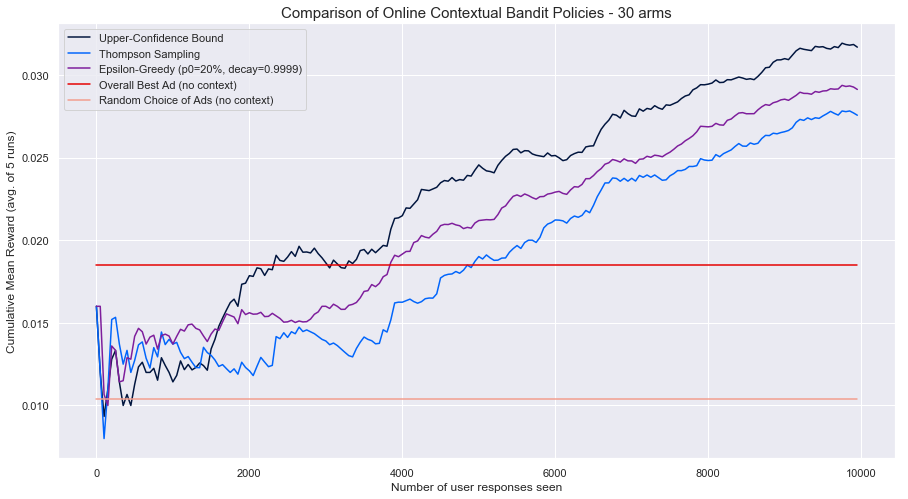

In [1164]:
show_result(title="Comparison of Online Contextual Bandit Policies - 30 arms")

### 3.2 Choice among 30 ads with sparse rewards 

This trial reduces the overall click-through rate from an average of c. 1% to c. 0.3-0.4%. We can immediately observe that the Contextual MAB algorithms perform significantly worse relative to a hypothetical algorithm that were to randomly choose an ad to display without taking the user context into account (the "pinkish" line). The reason for this is the sparsity of positive data to learn from. It takes on average of 300-400 trials of choosing one ad to come across only one case where a user actually clicked. With only 10,000 user trials overall and 30 possible ads to choose from each time, there is simply too little data to effectively learn from.

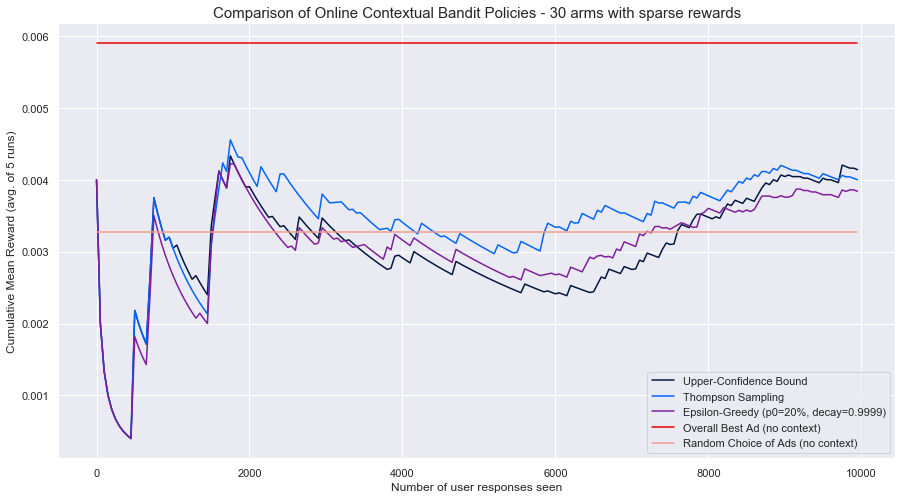

In [1172]:
show_result(title="Comparison of Online Contextual Bandit Policies - 30 arms with sparse rewards")

### 3.3 Choice among 10 ads

At a first glance, the advantage of a Contextual MAB relative to choosing ads at random is smaller than when we ran the same test for 30 different ad choices (see section 3.1.). This makes sense intuitively, since there are less areas (i.e., user groups) where knowledge of the user context confers a significant advantage in CTR. 

It also seems that epsilon-Greedy seems to do better relative to UCB when there are less arms to choose from. Since there are fewer arms, there is a lower chance for epsilon-Greedy over the short term to mostly exploit suboptimal arms (rather than spreading choices among a group of what are likely the best arms, as UCB and Thompson sampling do). 

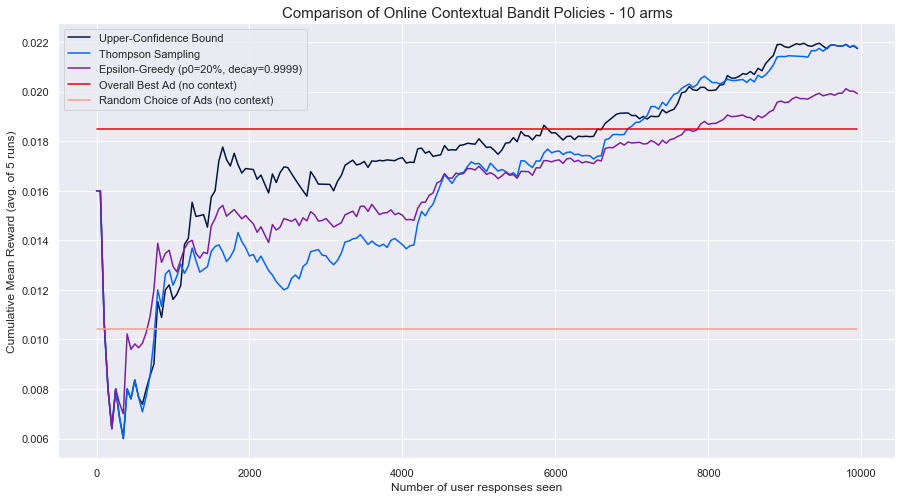

In [1149]:
show_result(title="Comparison of Online Contextual Bandit Policies - 10 arms")